# **🏠 부동산 실거래가 EDA**
## Contents
0. Library Import
1. Data Load 
2. Target value 분포 확인을 위한 histogram 확인
3. 범주형 클래스별 target value histogram overlay
4. 연속형 변수들 간의 correlation matrix


### **1. Library Import**
> 필요한 라이브러리를 불러옵니다.

In [1]:
# !pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [29]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
plt.rcParams['axes.unicode_minus'] = False 
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

### **2. Data Load**

> 아파트거래와 관련된 데이터를 살펴보기 위해 load해줍니다.

#### **2.1. 데이터 로드**

In [10]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/root/dev/Ml_Team2_fork/1.Data/train.csv'
test_path  = '/root/dev/Ml_Team2_fork/1.Data/test.csv'
train = pd.read_csv(train_path) # train set
test = pd.read_csv(test_path) # test set 

#### **2.2 데이터크기 확인**

In [ ]:
# Data shape check
print(f'train set shape : {train.shape} \ntest set shape : {test.shape}')

train set shape : (1118822, 52) 
test set shape : (9272, 51)


#### **2.3 데이터 정보 확인**

In [12]:
train.info()
# test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

#### **2.4 데이터 변수별 결측치 확인**

In [11]:
train.isnull().sum() # train set missing value check
# test.isnull().sum() # test set missing value check

시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적(㎡)                         0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1112839
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적      

#### **2.5 복잡한 변수명 간략화하기**
> k-전용면적별세대현황과 같이 복잡한 변수명을 간략화 한다.

In [13]:
# 문자열 변경을 위한 re import
import re

key_list = {}

for text in list(train.columns):
    # '전용면적별세대현황'으로 시작하면 괄호 제거 안함
    if text.startswith('k-전용면적별세대'): # 그냥 괄호를 제거하면 중복된 이름이 발생하기 때문에 처리한 예외 처리 
        cleaned = re.sub(r'^k-', '', text).strip()

    else :
        cleaned = re.sub(r'\(.*?\)','',text)
        cleaned = re.sub(r'^k-','',cleaned)
        cleaned = cleaned.strip()
    key_list[text] = cleaned
print(key_list)

{'시군구': '시군구', '번지': '번지', '본번': '본번', '부번': '부번', '아파트명': '아파트명', '전용면적(㎡)': '전용면적', '계약년월': '계약년월', '계약일': '계약일', '층': '층', '건축년도': '건축년도', '도로명': '도로명', '해제사유발생일': '해제사유발생일', '등기신청일자': '등기신청일자', '거래유형': '거래유형', '중개사소재지': '중개사소재지', 'k-단지분류(아파트,주상복합등등)': '단지분류', 'k-전화번호': '전화번호', 'k-팩스번호': '팩스번호', '단지소개기존clob': '단지소개기존clob', 'k-세대타입(분양형태)': '세대타입', 'k-관리방식': '관리방식', 'k-복도유형': '복도유형', 'k-난방방식': '난방방식', 'k-전체동수': '전체동수', 'k-전체세대수': '전체세대수', 'k-건설사(시공사)': '건설사', 'k-시행사': '시행사', 'k-사용검사일-사용승인일': '사용검사일-사용승인일', 'k-연면적': '연면적', 'k-주거전용면적': '주거전용면적', 'k-관리비부과면적': '관리비부과면적', 'k-전용면적별세대현황(60㎡이하)': '전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)': '전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하': '85㎡~135㎡이하', 'k-135㎡초과': '135㎡초과', 'k-홈페이지': '홈페이지', 'k-등록일자': '등록일자', 'k-수정일자': '수정일자', '고용보험관리번호': '고용보험관리번호', '경비비관리형태': '경비비관리형태', '세대전기계약방법': '세대전기계약방법', '청소비관리형태': '청소비관리형태', '건축면적': '건축면적', '주차대수': '주차대수', '기타/의무/임대/임의=1/2/3/4': '기타/의무/임대/임의=1/2/3/4', '단지승인일': '단지승인일', '사용허가여부': '사용허가여부', '관리비 업로드': '관리비 업로드

In [14]:
train = train.rename(columns = key_list)
test = test.rename(columns = key_list)

#### **2.6 Data Merge**
> * pd.concat 함수를 통해 train, test set을 병합하여 EDA를 진행한다.
> * 기본적으로 train set만 주어져있다는 가정이 있으므로 파생변수 생성, 스케일링을 진행 할때 test set의 데이터는 없는 것으로 취급

In [16]:
train['is_test'] = 0 # train, test split variable
test['is_test'] = 1
concat = pd.concat([train, test])

print(concat.shape)
print(concat['is_test'].value_counts())

(1128094, 53)
0    1118822
1       9272
Name: is_test, dtype: int64


### **3. Missing Value**
> 현재 데이터의 결측치가 얼마나 있는지 시각화와 수치를 통해 확인

#### **3.1 Missing value rate check!**

In [17]:
# concat data set missing value count & missing value ratio check! 

from wcwidth import wcswidth

# 텍스트의 '보이는 너비'를 기준으로 왼쪽 정렬하여 공백을 채워주는 함수
def pad_str(text, total_width):
    """한글, 영문, 이모지가 섞인 문자열의 보이는 너비를 계산해 정렬합니다."""
    text_width = wcswidth(str(text)) # 어떤 타입이든 문자열로 변환
    padding_size = total_width - text_width
    return str(text) + ' ' * padding_size

In [18]:
COL_WIDTH = 35
DTYPE_WIDTH = 25
NUNIQUE_WIDTH = 18
MISSING_WIDTH = 18

# header print
print(f"{pad_str('📌 컬럼명', COL_WIDTH)}| {pad_str('데이터타입', DTYPE_WIDTH)}| {pad_str('고유값', NUNIQUE_WIDTH)}| {pad_str('결측개수', MISSING_WIDTH)}| 결측률")
print("-" * (COL_WIDTH + DTYPE_WIDTH + NUNIQUE_WIDTH + MISSING_WIDTH + 20)) # 구분선


# 열 전체를 넣고 스캔하기
for col in concat.columns[np.argsort(concat.isnull().sum())[::-1]]:
    nunique = concat[col].nunique(dropna=False)
    missing_ratio = concat[col].isna().mean()
    missing_count = concat[col].isnull().sum()
    col_type = str(concat.dtypes[col])
    
    # 각 정보 덩어리를 pad_str 함수로 감싸 정렬합니다.
    col_str = pad_str(f"📌 {col}", COL_WIDTH)
    dtype_str = pad_str(f"데이터타입: {col_type}", DTYPE_WIDTH)
    nunique_str = pad_str(f"고유값: {nunique}", NUNIQUE_WIDTH)
    missing_str = pad_str(f"결측개수: {missing_count}", MISSING_WIDTH)

    print(f"{col_str}| {dtype_str}| {nunique_str}| {missing_str}| {missing_ratio:.2%}")


📌 컬럼명                          | 데이터타입               | 고유값            | 결측개수          | 결측률
--------------------------------------------------------------------------------------------------------------------
📌 135㎡초과                       | 데이터타입: float64      | 고유값: 2         | 결측개수: 1127765 | 99.97%
📌 해제사유발생일                  | 데이터타입: float64      | 고유값: 1034      | 결측개수: 1121899 | 99.45%
📌 등록일자                        | 데이터타입: object       | 고유값: 128       | 결측개수: 1116386 | 98.96%
📌 단지소개기존clob                | 데이터타입: float64      | 고유값: 95        | 결측개수: 1058958 | 93.87%
📌 홈페이지                        | 데이터타입: object       | 고유값: 222       | 결측개수: 1013523 | 89.84%
📌 고용보험관리번호                | 데이터타입: object       | 고유값: 527       | 결측개수: 920757  | 81.62%
📌 세대전기계약방법                | 데이터타입: object       | 고유값: 3         | 결측개수: 885389  | 78.49%
📌 팩스번호                        | 데이터타입: object       | 고유값: 1386      | 결측개수: 879348  | 77.95%
📌 시행사                          | 데이터타입: object     

> 결측률이 높은 변수들이 상당히 많은 것으로 보여진다. 이를 한 눈에 보기쉽게 시각화

#### **3.2 Missing value rate 시각화**
> Missing value rate를 수치를 통해 살펴보는 것은 한 눈에 알아보기 쉽지 않기 때문에 시각화를 진행하여 가시성을 높인다.

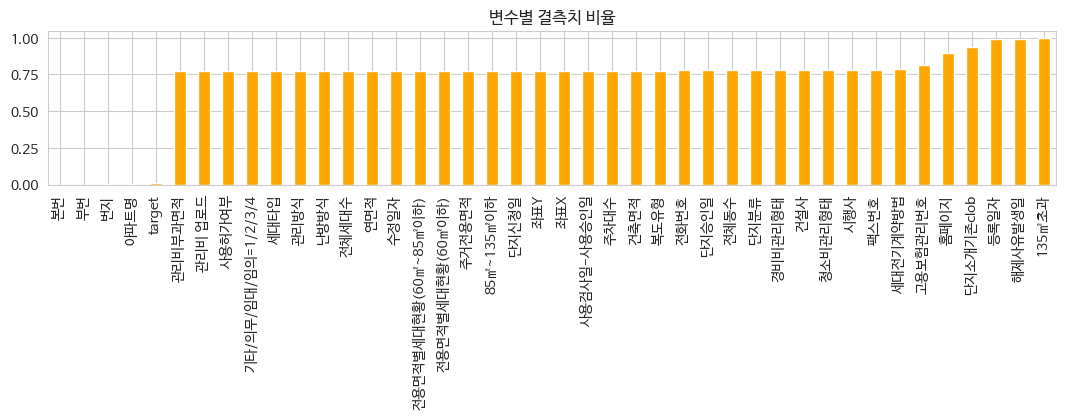

In [19]:
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

#### **3.3 Missing value rate 30% 이상 변수 제거**

> * 관리피부과면적부터 135m초과 까지 결측률이 70%이상인 것을 확인 할 수 있다. 일반적으로 30%정도만 되도 결측치를 채워넣을 수 있지 않는 이상 다른 변수들을 통해 보간하는 것은 무의미하다고 판단이 된다.
> * 따라서 결측률 30%를 임계치로 정하여 삭제

In [20]:
# 결측률이 30% 이상인 변수 삭제
print('✅  결측률이 30% 미만 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0]  < 0.3]))     # 남겨질 변수들은 아래와 같습니다.
print('❌  결측률이 30% 이상 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0] >= 0.3]))

✅  결측률이 30% 미만 변수 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'target', 'is_test']
❌  결측률이 30% 이상 변수 : ['해제사유발생일', '단지분류', '전화번호', '팩스번호', '단지소개기존clob', '세대타입', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사', '시행사', '사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과', '홈페이지', '등록일자', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일']


In [ ]:
# 결측률 30% 이상인 변수들 삭제
concat.drop(columns = list(concat.columns[concat.isnull().sum()/concat.shape[0]  >= 0.3]), axis = 1, inplace = True) 

#### **3.4 결측치는 아닌데 의미 없는 형식적인 값 찾기**
> ' ', '-', '없음', '9999', '-9999', 'nan' 과 같이 범주형 변수의 의미가 없는 형식적인 값을 찾아내어 결측치 처리를 한다.

In [22]:
# 결측치는 아닌데 의미 없는 형식적 값 찾는 함수

def detect_fake_nulls(df, suspect_values=['-', ' ', '', '.', '없음', 'nan']):
    result = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            val_counts = df[col].value_counts(dropna=False)
            found = val_counts[val_counts.index.isin(suspect_values)]
            if not found.empty:
                result[col] = found
    return result

fake_nulls = detect_fake_nulls(concat)
for col, vals in fake_nulls.items():
    print(f"🔎 {col} 컬럼에서 의미 없는 값 발견:")
    print(vals)
    print()

🔎 도로명 컬럼에서 의미 없는 값 발견:
     1211
Name: 도로명, dtype: int64

🔎 등기신청일자 컬럼에서 의미 없는 값 발견:
     1111271
Name: 등기신청일자, dtype: int64

🔎 거래유형 컬럼에서 의미 없는 값 발견:
-    1086451
Name: 거래유형, dtype: int64

🔎 중개사소재지 컬럼에서 의미 없는 값 발견:
-    1090013
Name: 중개사소재지, dtype: int64



In [23]:
# 아무 의미 없는 값 결측처리를 위해 nan으로 변경
concat['도로명'] = concat['도로명'].replace(' ', np.nan)
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

> 결측률이 30%이상인 새로운 변수들이 생겼으므로 다시 한번 삭제를 해준다.

In [24]:
# 결측률이 30% 이상인 변수 확인
print('✅  결측률이 30% 미만 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0]  < 0.3]))     # 남겨질 변수들은 아래와 같습니다.
print('❌  결측률이 30% 이상 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0] >= 0.3]))

✅  결측률이 30% 미만 변수 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'target', 'is_test']
❌  결측률이 30% 이상 변수 : ['등기신청일자', '거래유형', '중개사소재지']


In [44]:
# 결측률 30% 이상인 변수들 삭제
concat.drop(columns = list(concat.columns[concat.isnull().sum()/concat.shape[0]  >= 0.3]), axis = 1, inplace = True) 

### **3. 연속형 변수**
> 연속형 변수의 대한 EDA

#### **3.1 Target value**
> 가장 중요한 아파트 거래가격 EDA

In [6]:
# skewness 확인을 위한 skew 함수 로드
from scipy.stats import skew

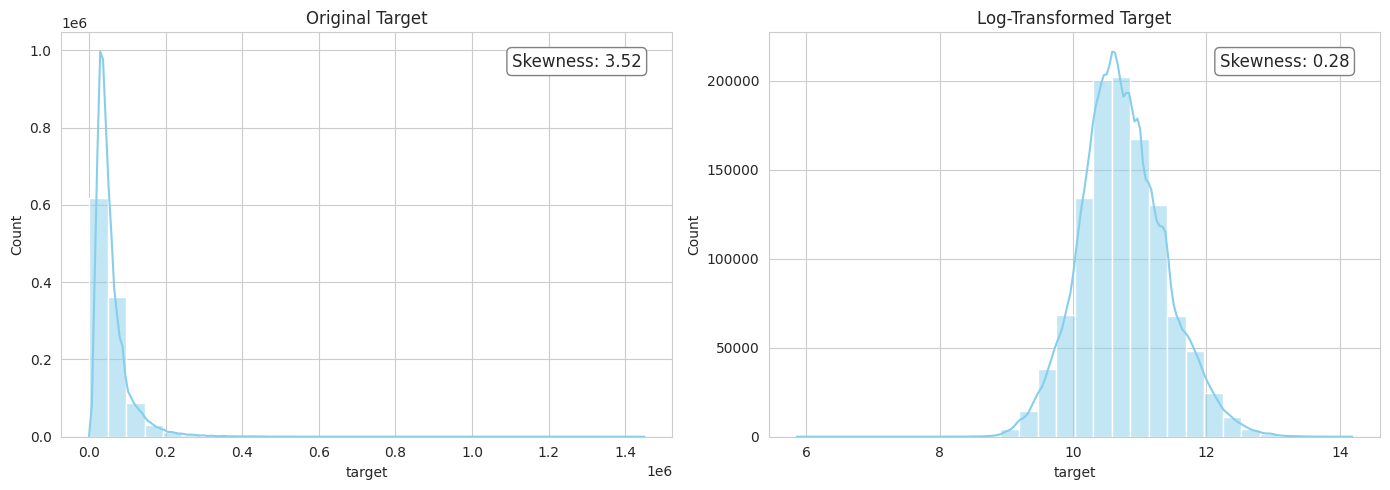

In [27]:
# 원본, 로그변환 데이터
targets = [train['target'], np.log1p(train['target'])]
titles = ['Original Target', 'Log-Transformed Target']

# 서브플롯
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.set_style('whitegrid')

for i, (data, title) in enumerate(zip(targets, titles)):
    skew_val = skew(data)
    sns.histplot(data, kde=True, ax=axes[i], color='skyblue', bins=30)
    axes[i].set_title(title)
    
    # 왜도 값 텍스트로 표시 (오른쪽 상단)
    axes[i].text(
        0.95, 0.95, 
        f'Skewness: {skew_val:.2f}', 
        transform=axes[i].transAxes,  # 축 상대 좌표계
        ha='right', va='top',
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')
    )

plt.tight_layout()
plt.show()

> * target value에 분포를 살펴보기 위해 histogram을 시각화하였다 보는거와 같이 왼쪽으로 치우쳐져 있는 것으로 생각이 되어 skewness를 계산해보니 3.52로 왼쪽으로 치우쳐져 있는 모습을 볼 수 있다.
> * 치우쳐져있는 분포를 완화하기 위해 log scaling을 한 결과 skewness가 0.28로 완화되는 모습을 확인할 수 있다.
> * 이를 통해 모형 학습은 log scale target value으로 하는 것이 적절하게 생각된다

#### **3.2 계약년월**
> 시간관련 변수인 계약년월을 EDA

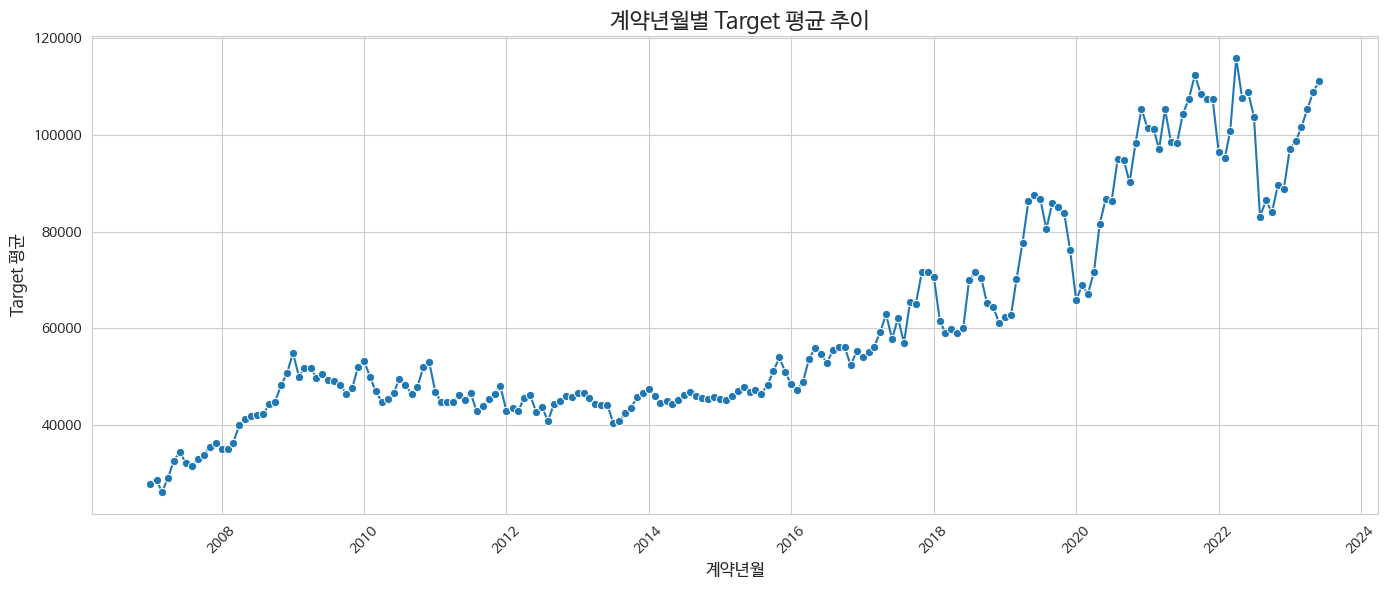

In [30]:
# 계약년월 예: 201806 
# concat['계약년월'] = pd.to_datetime(concat['계약년월'].astype(str), format="%Y%m")

# 시계열 기준 groupby 평균
monthly_mean = concat.groupby('계약년월')['target'].mean().reset_index()
monthly_mean['계약년월'] = pd.to_datetime(monthly_mean['계약년월'].astype(str), format="%Y%m")


# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_mean, x='계약년월', y='target', marker='o')

# 제목과 라벨 꾸미기
plt.title('📈 계약년월별 Target 평균 추이', fontsize=16)
plt.xlabel('계약년월', fontsize=12)
plt.ylabel('Target 평균', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> 1. 계약년월에 따른 집값은 우상향 추세가 있는 것으로 보여짐
> 2. 2008년 12월과 2009년 1월에 차이는 실제로 한달이지만 모형에 정수형으로 input값이 들어가게 된다면 89에 숫자차이가 발생
> 3. 이를 해결하기 위한 방안
>> 1. 계약 년, 월을 구분하여 파생변수를 생성하여 범주화 -> 시간에 흐름에 따른 증가를 반영하지 못하게 될 수도 있음
>> 2. 계약 년만 따로 변수로 생성 -> seanality가 있을 시 반영 못할 수도 있음
>> 3. 계약년월을 int형태로 변화하여 2008년에서 2009년으로 넘어가는 해가 넘어가는 시점의 차이를 없애기 ✅ 제일 먼저 고려해볼만 함
> 4. 계약년월에서 월에 해당하는 부분이 계절성이 있는지를 살펴볼 필요가 있음 -> 계절성이 있다면 월마다 범주 처리 없다면 정수처리

#### **3.2 계약년월-시계열 분석**

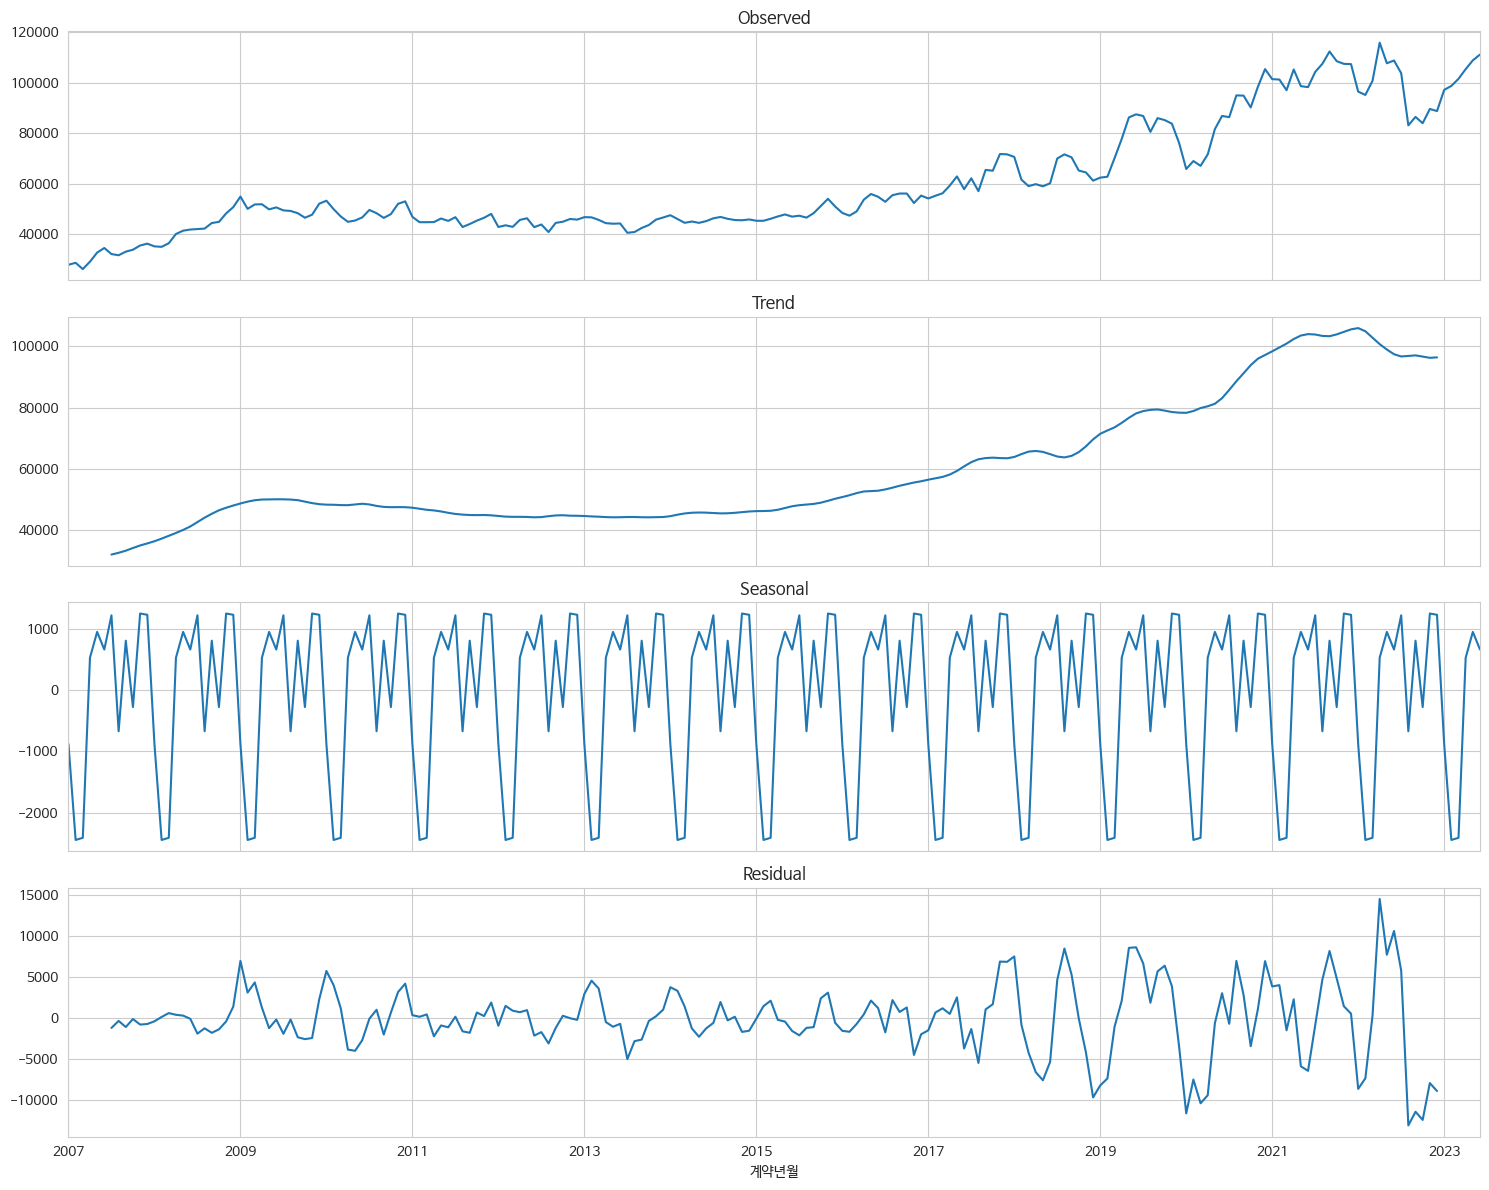

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

monthly_mean = concat.groupby('계약년월')['target'].mean().dropna().reset_index()
monthly_mean['계약년월'] = pd.to_datetime(monthly_mean['계약년월'].astype(str), format="%Y%m")

monthly_mean_ts = monthly_mean.set_index('계약년월')['target']

monthly_mean
decomposition = seasonal_decompose(monthly_mean_ts, model='additive', period=12);


trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid
observed = decomposition.observed

fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

observed.plot(ax=axs[0], title='Observed')
trend.plot(ax=axs[1], title='Trend')
seasonal.plot(ax=axs[2], title='Seasonal')
resid.plot(ax=axs[3], title='Residual')

plt.tight_layout()
plt.show()


**시계열분석 결과해석**
|구성요소|해석|
|-----|----------------------------------------|
|Trend|2015년 이후 정도부터 추세선이 상승, 2019 ~ 2021 급등, 2022년 부터 꺾임
|Seasonal|명확한 계절성 존재(봄-가을 상승, 겨울 하락)
|Residual|2020년 이후 residual이 매우 커짐 외부 충격으로 생각됨(코로나, 정책 등)


<br>

=================================================

**위 같은 결과해석으로 인해 생각 할 수 있는 파생변수**

> 1. 계약시간 201812, 201901의 수치적 차이는 약 90의 달함 이 같은 수치적차이를 월에 해당하는 부분을 12로 나누어 해결
> 2. 계약월 : 1 ~ 12월을 범주형
> 3. 계절 : 봄 여름 가을 겨울 범주형
> 4. 특정이벤트 여부 반영 : 코로나 2020.01 이후 이전, 특정 정책 이후 이전

#### **3.2 계약년월 - 파생변수 만들기**

In [53]:
# 파생변수 만들기 
concat['contract_month'] = concat['계약년월'] % 100 # 계약월
concat['contract_date'] = concat['계약년월'] // 100 + concat['contract_month'] / 12 # 계약시간
concat['covid'] = (concat['계약년월'] >= 202001).astype(int) # 코로나 시기 구분

#### **3.3 계약일**
> 계약일 EDA

<Axes: xlabel='계약일', ylabel='target'>

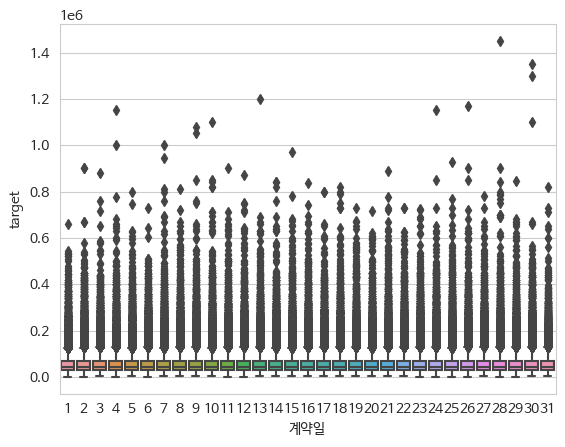

In [40]:
# 계약일 별 boxplot
temp = concat.sort_values('계약일')
sns.boxplot(x = temp['계약일'].astype('str'), y = temp['target'])

> * 박스플랏을 통해 계약일 별로 분포의 차이가 있는지 살펴보기 위한 그림을 그렸다.
> * 범주가 많아 분포의 차이가 있는지 육안으로 확인하기 힘들지만, 일단 육안으로 보기에는 분포의 차이가 있는 것으로 보여지진 않는다.
> * 좀 더 확실히 하기 위해 분포의 차이가 있는지 등분산성 검정, ANOVA를 통해 분포의 차이를 수치적으로 확인

#### **3.3 계약일 - 검정을 통한 분포차이 확인**

In [45]:
from scipy.stats import levene, f_oneway

# 임시 결측행 제거
temp = concat.dropna()

# 지역별 그룹 나누기
groups = [group['target'].values for name, group in temp.groupby('계약일')]

# 등분산 검정
stat, p = levene(*groups)
print(f"📊 Levene 등분산 검정 통계량: {stat:.4f}, p-value: {p:.4f}")

# ANOVA 검정
stat, p = f_oneway(*groups)
print(f"📊 F-statistic: {stat:.4f}, p-value: {p:.4f}")

📊 Levene 등분산 검정 통계량: 4.4625, p-value: 0.0000
📊 F-statistic: 6.9263, p-value: 0.0000


> * 그룹간 Levene 등분산 검정과 ANOVA를 통해 분포에는 차이가 없는 것으로 보여진다.
> * 즉 일자별로 집값의 가격이 다르다고 할 수 없기 때문에 해당 변수는 집값의 영향력이 작다고 할 수 있다.

#### **3.4 건축년도**
> 지어진 건물이 얼마나 오래되었는지 확인 할 수 있는 변수

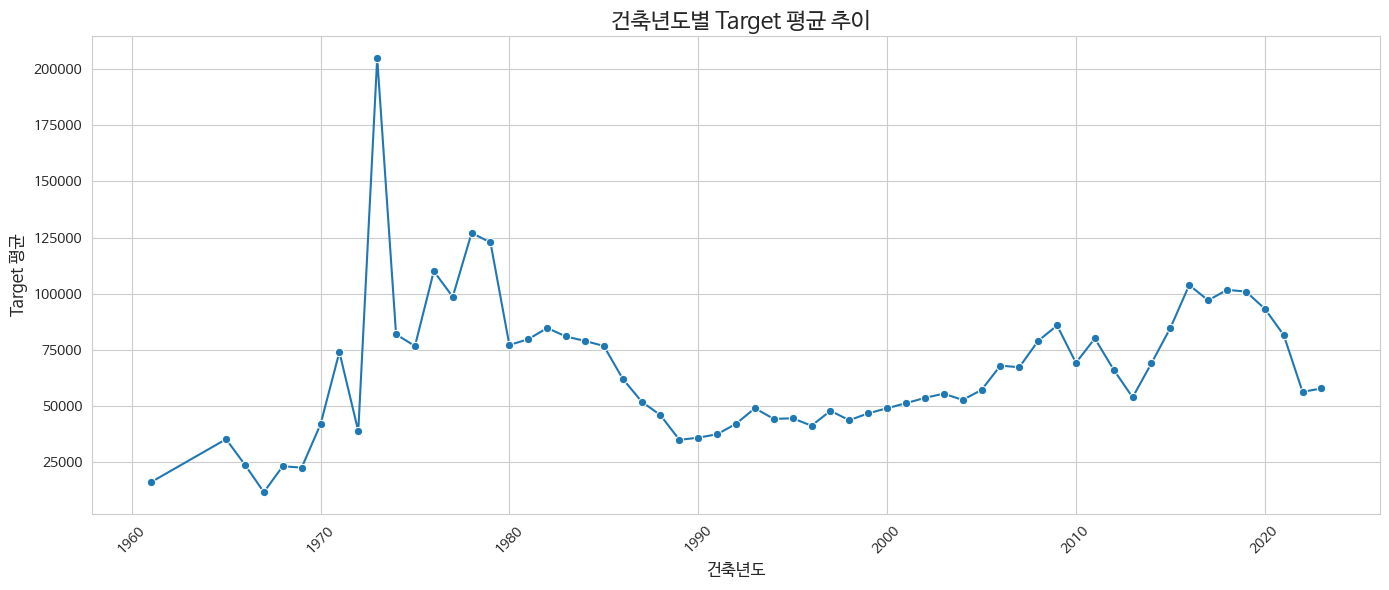

In [46]:
# 건축년도: 1961, 2023
# concat['건축년도'] = pd.to_datetime(concat['건축년도'].astype(str), format="%Y%m")

# 시계열 기준 groupby 평균
construct_year_mean = concat.groupby('건축년도')['target'].mean().reset_index()
construct_year_mean['건축년도'] = pd.to_datetime(construct_year_mean['건축년도'].astype(str), format="%Y")


# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(data=construct_year_mean, x='건축년도', y='target', marker='o')

# 제목과 라벨 꾸미기
plt.title('📈 건축년도별 Target 평균 추이', fontsize=16)
plt.xlabel('건축년도', fontsize=12)
plt.ylabel('Target 평균', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> * stage AI에 있는 board에 있는 내용으로 1973년에 부촌에 해당하는 서초구 반포동에 그때 당시에 대규모 약 3590세대로 지어진 아파트가 분양을 시작하며, 부촌 특성상 높은 가격에 거래하였기 때문에 평균이 함께 증가한 사례
> * 전체적으로 아파트가 오래될 수록 가격이 낮고 최신 아파트 일수록 가격이 높은 우상향 추세가 있지만, 간혹 오래된 아파트는 재개발 기대로 인해 가격이 높아지는 경우도 발생한다.

#### **3.4 건축년도 - 거래량이 평균 가격에 영향을 미칠까?**

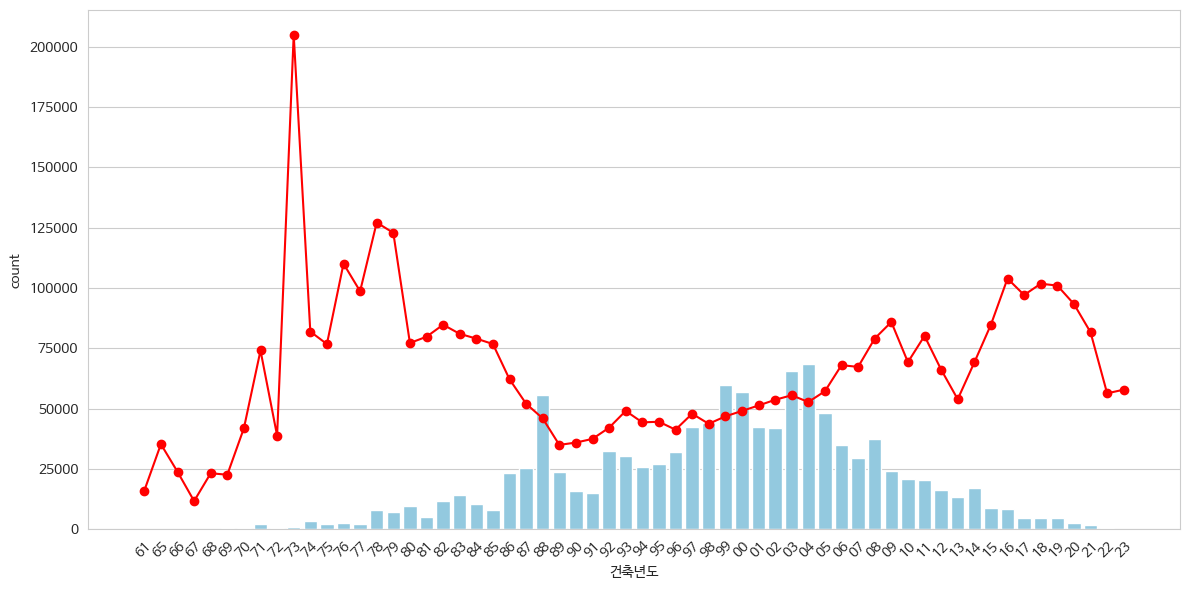

In [47]:
temp = concat.groupby('건축년도')['target'].agg(['count','mean'])

plt.figure(figsize = (12,6))
sns.barplot(data = temp, x = temp.index, y = 'count', color = 'skyblue')

plt.plot(range(len(temp.index)), temp['mean'], color='red', marker='o', label='평균 집값')

plt.xticks(
    ticks=range(len(temp.index)), 
    labels=[str(x)[-2:] for x in temp.index], 
    rotation=45,
    fontsize = 10
);
plt.tight_layout()
plt.show()

In [48]:
mini = min(concat[concat['건축년도'] == 1973]['target'])
maxi = max(concat[concat['건축년도'] == 1973]['target'])
num = len(concat[concat['건축년도'] == 1973]['target'])


print(f'1973년도 건축된 건물 가격 최대 : {maxi}, 최소 : {mini}, 거래 수 : {num}')

1973년도 건축된 건물 가격 최대 : 730000.0, 최소 : 8000.0, 거래 수 : 1049


> * Barplot으로 거래량을 표현한 것이지만 오래된 건물일수록 투자기대로 인해 거래량이 많아지는 것처럼 보여지지도 않아보인다.
> * 거래량이 많다고 평균 가격이 커지는 것처럼 보여지지는 않는다.
> * 이상치로 판단되는 1973년을 구분하는 이진 변수를 파생변수로 만드는 것도 좋은 생각이지만, 그 수가 1049건으로 매우 적어 변수를 만드는 의미가 퇴색될 가능성이 크다.

#### **3.4 건축년도 - 파생변수 만들기**

In [52]:
# 빌딩의 나이
current = 2025
concat['apt_age'] = current - concat['건축년도']

# 연식 구분 89년이전 old, 90년이후 new
concat['new_old'] = ['old' if 1989 >= i else 'new' for i in concat['건축년도']]

#### **3.5 연속형변수들 간 상관관계**
> * Target value와의 높은 상관관계를 갖는 변수를 중요변수로 판단
> * input variable간에 높은 상관관계 살펴보기

In [54]:
# categorical column name, numerical column name return function
def split_categorical_numerical(df:pd.DataFrame, verbose:bool = True):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if verbose:
        print("📌 범주형 변수:", categorical_cols)
        print("📌 연속형 변수:", numerical_cols)
    return categorical_cols, numerical_cols

# update variable list
cat_cols, num_cols = split_categorical_numerical(concat)

📌 범주형 변수: ['시군구', '번지', '아파트명', '도로명', 'new_old']
📌 연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test', 'apt_age', 'contract_month', 'contract_date', 'covid']


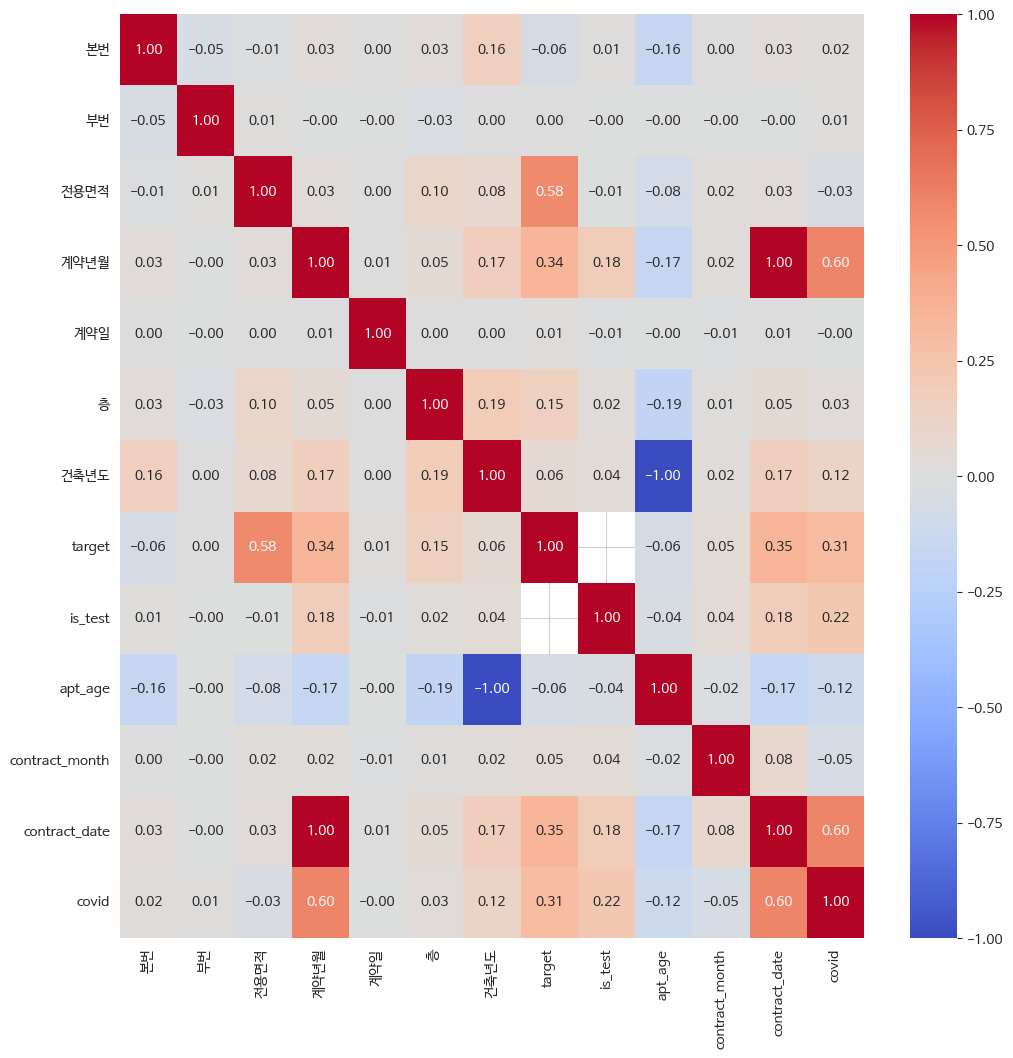

In [60]:
plt.figure(figsize = (12,12))

sns.heatmap(concat[num_cols].corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.show()

> * 만들어둔 파생변수와 높은 상관관계를 지니는 본 변수를 삭제, 병합 등을 이용해서 처리를 할 필요가 있어보인다.
> * 현재 target과 어느정도 상관관계를 보이고 있는 contract_date, covid, 전용면적들이 예측성능의 크게 기여할 것으로 기대 된다.

### **4. 범주형 클래스별 target value histogram overlay**

#### **4.0 범주형 변수 확인**

In [70]:
temp = pd.concat([train, test])
temp['target_log'] = np.log1p(temp['target'])

In [71]:
temp['구'] = temp['시군구'].map(lambda x : x.split(' ')[1])
temp['동'] = temp['시군구'].map(lambda x : x.split(' ')[2])
del temp['시군구']

In [72]:
# update variable list
cat_cols, num_cols = split_categorical_numerical(temp)

📌 범주형 변수: ['번지', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', '단지분류', '전화번호', '팩스번호', '세대타입', '관리방식', '복도유형', '난방방식', '건설사', '시행사', '사용검사일-사용승인일', '홈페이지', '등록일자', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '구', '동']
📌 연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', '해제사유발생일', '단지소개기존clob', '전체동수', '전체세대수', '연면적', '주거전용면적', '관리비부과면적', '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', 'target_log']


#### **4.1 청소비관리형태**
> 건물청소를 어떻게 관리하는지에 대한 변수

<Axes: xlabel='target', ylabel='Density'>

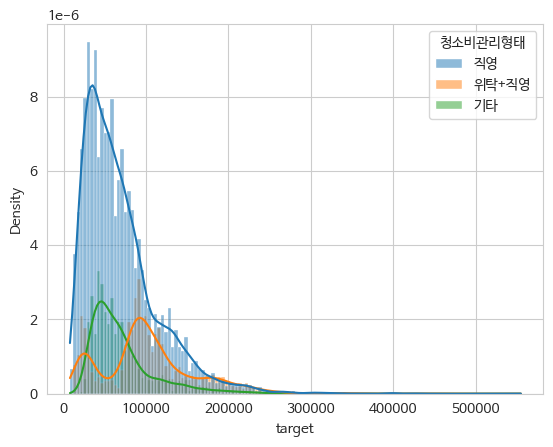

In [73]:
# 청소비관리형태

sns.histplot(data = temp[temp['청소비관리형태'] != '위탁'], x = 'target', hue ='청소비관리형태', kde = True, stat = 'density', alpha = .5)
# sns.histplot(data = temp, x = 'target', hue ='청소비관리형태', kde = True, stat = 'density', alpha = .5)

# target_log
# sns.histplot(data = temp[temp['청소비관리형태'] != '위탁'], x = 'target_log', hue ='청소비관리형태', kde = True, stat = 'density', alpha = .5)
# sns.histplot(data = temp, x = 'target_log', hue ='청소비관리형태', kde = True, stat = 'density', alpha = .5)

> 일단 압도적으로 직영의 관측수가 너무 많고 청소비관리형태에 따라 차이가 있다고 보기에는 어려워보임.

#### **4.2 세대전기계약방법**
> * 계약방법에 대한 변수 단일계약, 종합계약으로 이루어져있음

<Axes: xlabel='target_log', ylabel='Density'>

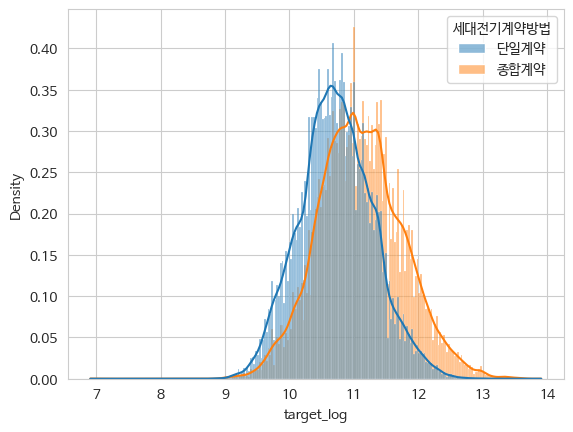

In [74]:
# 세대전기계약방법

# sns.histplot(data = temp, x = 'target', hue ='세대전기계약방법', kde = True, stat = 'density', alpha = .5)

# target_log
sns.histplot(data = temp, x = 'target_log', hue ='세대전기계약방법', kde = True, stat = 'density', alpha = .5)



> * 비슷한 크기의 관측치와 종합계약인 경우 다소 높은 가격대를 형성하고 있는 것을 확인 할 수 있다.
> * 하지만 분포간의 차이가 있다고 보기에는 큰 차이는 없어보여 영향력이 적을 것으로 보여짐

#### **4.3 경비비관리형태**
> 청소비와 맞찬가지로 경비비를 어떤형식으로 관리하는지에 대한 변수

<Axes: xlabel='target', ylabel='Density'>

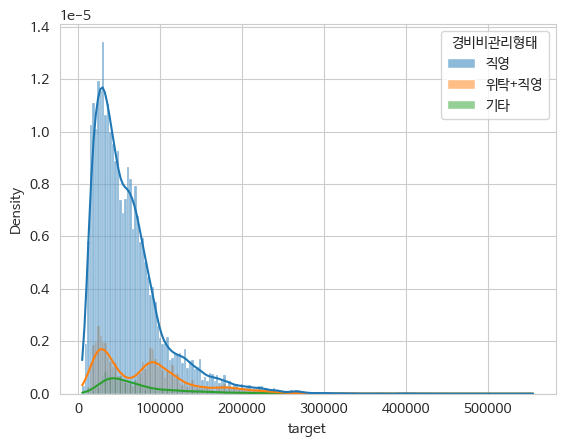

In [75]:
# 경비비관리형태

sns.histplot(data = temp[temp['경비비관리형태'] != '위탁'], x = 'target', hue ='경비비관리형태', kde = True, stat = 'density', alpha = .5)
# sns.histplot(data = temp, x = 'target', hue ='경비비관리형태', kde = True, stat = 'density', alpha = .5)

# target_log
# sns.histplot(data = temp[temp['경비비관리형태'] != '위탁'], x = 'target_log', hue ='경비비관리형태', kde = True, stat = 'density', alpha = .5)
# sns.histplot(data = temp, x = 'target_log', hue ='경비비관리형태', kde = True, stat = 'density', alpha = .5)



#### **4.3 세대타입**
> 분양, 기타, 임대로 구분지어져있는 변수

<Axes: xlabel='target_log', ylabel='Density'>

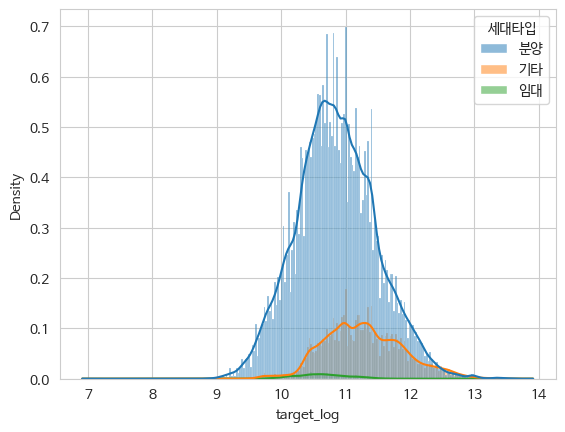

In [ ]:
# 세대타입
# sns.histplot(data = temp[temp['세대타입'] != '분양'], x = 'target', hue ='세대타입', kde = True, stat = 'density', alpha = .5)
# sns.histplot(data = temp, x = 'target', hue ='세대타입', kde = True, stat = 'density', alpha = .5)

# target_log
# sns.histplot(data = temp[temp['세대타입'] != '분양'], x = 'target_log', hue ='세대타입', kde = True, stat = 'density', alpha = .5)
sns.histplot(data = temp, x = 'target_log', hue ='세대타입', kde = True, stat = 'density', alpha = .5)



> 세대타입으로 큰 구분은 힘들어 보임, 기타 임대끼리 비교했을 때 비교적 임대를 한 세대타입이 상대적으로 낮은 금액대를 형성하지만 수가 압도적으로 적고 유의미하게 분포가 차이가 나지 않아 분리가 힘들어 보임

#### **4.4 난방방식**

|구분|개별난방|중앙난방|지역난방|
|---|---------|-----------------|--------------|
|열원위치|각 세대별 보일러| 아파트 단지 내 중앙 보일러실 | 외부 지역 열원시설|
|관리 방식| 개인이 관리| 관리사무소에서 관리|외부 열공급 업체가 공급|
|요금|자율 조절 가능|공급 비례 부과|외부 요금 체계 적용|
|유지보수|개인 부담|단지 부담|공급 업체 부담|

지역난방은 주로 수도권 신도시(판교, 위례, 세종시 등)이나 최근 지은 대형 아파트 단지, 난방공사와 연계된 도시 기반 시설지역에 많이 설치되어 있음

<Axes: xlabel='target', ylabel='Density'>

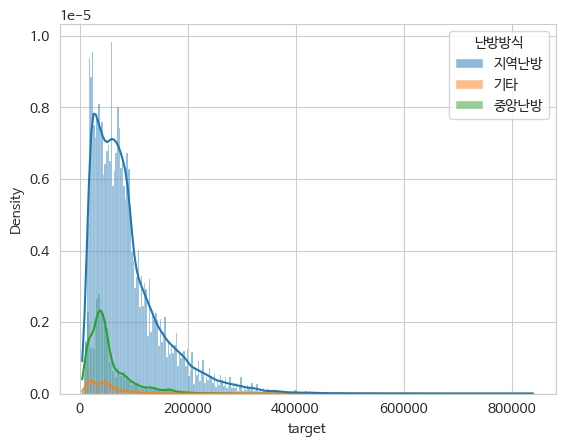

In [76]:
# 난방방식

sns.histplot(data = temp[temp['난방방식'] != '개별난방'], x = 'target', hue ='난방방식', kde = True, stat = 'density', alpha = .5)
# sns.histplot(data = temp, x = 'target', hue ='난방방식', kde = True, stat = 'density', alpha = .5)

# target_log
# sns.histplot(data = temp[temp['난방방식'] != '개별난방'], x = 'target_log', hue ='난방방식', kde = True, stat = 'density', alpha = .5)
# sns.histplot(data = temp, x = 'target_log', hue ='난방방식', kde = True, stat = 'density', alpha = .5)



> 절대 다수를 차지하고 있는 개별난방을 제외하고 histogram을 살펴봐도 각 범주별로 분포의 차이가 있어보인다고 보긴 힘들다.

#### **4.5 복도유형**
> 아파트 형태가 복도유형인지 계단식인지 타워형인지 구분하는 변수

<Axes: xlabel='target_log', ylabel='Density'>

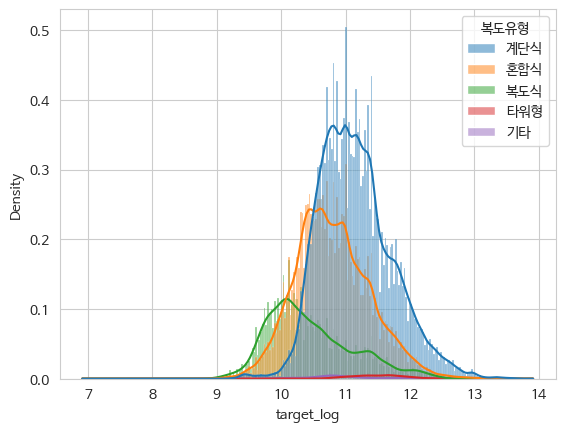

In [77]:
# 복도유형

# sns.histplot(data = temp[temp['복도유형'] != '계단식'], x = 'target', hue ='복도유형', kde = True, stat = 'density', alpha = .5)
# sns.histplot(data = temp, x = 'target', hue ='복도유형', kde = True, stat = 'density', alpha = .5)

# target_log
# sns.histplot(data = temp[temp['복도유형'] != '계단식'], x = 'target_log', hue ='복도유형', kde = True, stat = 'density', alpha = .5)
sns.histplot(data = temp, x = 'target_log', hue ='복도유형', kde = True, stat = 'density', alpha = .5)


> * 계단식에 비해 복도식이 조금 저가형으로 보여짐 분포의 중심이 다른 것으로 보여져 변수로서 모델에 추가가된다면 무의미하지 않을 것으로 생각되지만 큰 영향은 없을 것으로 사료됨 

#### **4.6 관리방식**

<Axes: xlabel='target', ylabel='Density'>

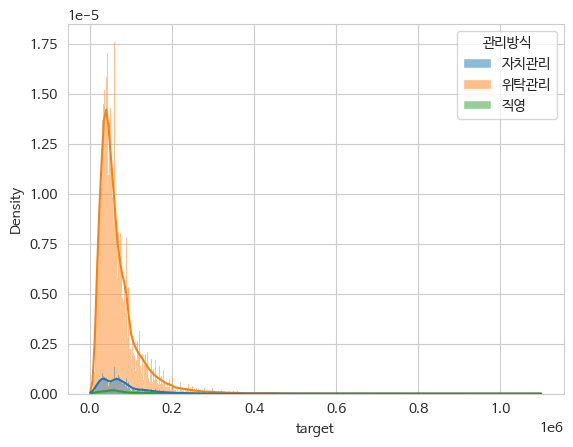

In [79]:
# 관리방식
# sns.histplot(data = temp[temp['관리방식'] != '위탁관리'], x = 'target', hue ='관리방식', kde = True, stat = 'density', alpha = .5)
sns.histplot(data = temp, x = 'target', hue ='관리방식', kde = True, stat = 'density', alpha = .5)

# target_log
# sns.histplot(data = temp[temp['관리방식'] != '위탁관리'], x = 'target_log', hue ='관리방식', kde = True, stat = 'density', alpha = .5)
# sns.histplot(data = temp, x = 'target_log', hue ='관리방식', kde = True, stat = 'density', alpha = .5)

> 관리방식에 차이에 따라 주택가격에 차이가 있어보이지는 않아 보임

#### **4.7 단지분류**
> * 일반적으로 주상복합, 연립주택 유동인구가 많은 대도시 중심지에 고가의 건물
> * 생활주택은 상대적으로 저가인 건물이 주를 이루고 있음

<Axes: xlabel='target', ylabel='Density'>

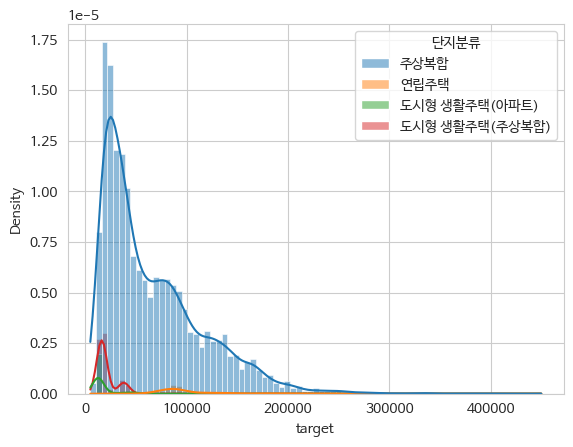

In [81]:
sns.histplot(data = temp[temp['단지분류'] != '아파트' ], x = 'target', hue = '단지분류', kde = True, stat = 'density', alpha = .5)
# sns.histplot(data = temp, x = 'target_log', hue = '단지분류', kde = True, stat = 'density', alpha = .5)

#### **4.8 기타/의무/임대/임의**

<Axes: xlabel='target', ylabel='Density'>

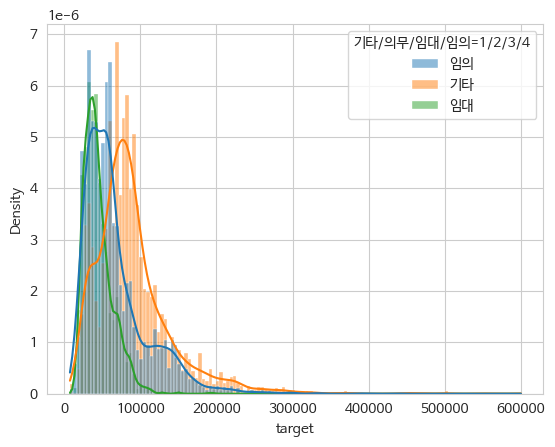

In [82]:
sns.histplot(data = temp[temp['기타/의무/임대/임의=1/2/3/4'] != '의무'], x = 'target', hue = '기타/의무/임대/임의=1/2/3/4', alpha = .5, stat = 'density', kde = True)
# sns.histplot(data = temp, x = 'target', hue = '기타/의무/임대/임의=1/2/3/4', alpha = .5, stat = 'density', kde = True)

> '기타/의무/임대/임의=1/2/3/4' 해당 feature는 절대 다수인 의무를 제외한 값으로 histogram을 살펴본 결과 범주간의 분포에 큰 차이가 없어보인다.